In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import libpysal as lps
import mapclassify as mc
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter('ignore')


In [50]:
india = gpd.read_file('zip://./India_NLEP_HMIS_NFHS.zip')

In [7]:
wq =  lps.weights.Queen.from_dataframe(india)
wq.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 288, ' is an island (no neighbors)')


In [8]:
for year in range(2008,2018):
    #incidence
    y1 = india[f'{year}_I.Rat']
    y1lag = lps.weights.lag_spatial(wq, y1)
    y1lagfj10 = mc.Fisher_Jenks(y1lag, k=10)
    india[f'{year}_iR_sp'] = y1lag
    india[f'{year}_Class'] = y1lagfj10.yb
    #Prevalence
    y3 = india[f'{year}_P.Rat']
    y3lag = lps.weights.lag_spatial(wq, y3)
    india[f'{year}_pR_sp'] = y3lag

In [9]:
india1 = india[['NAME_1','NAME_2'] + [f'{year}_I.Rat' for year in range(2008,2018)]
               + [f'{year}_iR_sp' for year in range(2008,2018)]
               + [f'{year}_P.Rat' for year in range(2008,2018)]
               + [f'{year}_pR_sp' for year in range(2008,2018)]
               + [f'{year}_Class' for year in range(2008,2018)]
               + [f'{year}_RBD' for year in range(2009,2017)]]
india1['2008_RBD'] = india['2009_RBD']
india1['2017_RBD'] = india['2016_RBD']

In [10]:
nlepts = pd.DataFrame(columns=['State','District','Year','iRate','pRate','RBD','iRate_sp','pRate_sp','Class'])

In [11]:
num = 0

for a,b in india1.iterrows():
    for year in range(2008,2018):
        nlepts.loc[num, 'State'] = b['NAME_1']
        nlepts.loc[num, 'District'] = b['NAME_2']
        nlepts.loc[num, 'Year'] = year
        nlepts.loc[num, 'iRate'] = b[f'{year}_I.Rat']
        nlepts.loc[num, 'pRate'] = b[f'{year}_P.Rat']
        nlepts.loc[num, 'Class'] = b[f'{year}_Class']
        nlepts.loc[num, 'RBD'] = b[f'{year}_RBD']
        try:
            nlepts.loc[num, 'iRate_sp'] = b[f'{year-1}_iR_sp']
            nlepts.loc[num, 'pRate_sp'] = b[f'{year-1}_pR_sp']
            nlepts.loc[num, 'RiRate'] = b[f'{year-1}_I.Rat']
            nlepts.loc[num, 'RpRate'] = b[f'{year-1}_P.Rat']
            num+=1
        except Exception as e:
            nlepts.loc[num, 'iRate_sp'] = b[f'{year}_iR_sp']
            nlepts.loc[num, 'pRate_sp'] = b[f'{year}_pR_sp']
            nlepts.loc[num, 'RiRate'] = b[f'{year}_I.Rat']
            nlepts.loc[num, 'RpRate'] = b[f'{year}_P.Rat']
            num+=1

            

In [235]:
special_Focues_Village = nlepts[nlepts['Year'] == 2013].sort_values('iRate')[-230:]['District'].tolist()
nlepts['Focus'] = 1
nlepts.loc[(nlepts['Year'] > 2012) & (nlepts['District'].isin(special_Focues_Village)),'Focus'] = -1
nlepts.loc[(nlepts['Year'] ==  2017) & (nlepts['District'].isin(special_Focues_Village)),'Focus'] = 3

In [236]:
nlepts16 = nlepts.copy()
# nlepts16['YF'] = nlepts16['Year'] * nlepts16['Focus']
# nlepts16['I_spF'] = nlepts16['iRate_sp'] * nlepts16['Focus']
# nlepts16['RBD_F'] = nlepts16['RBD'] * nlepts16['Focus']

nlepts16= nlepts16[nlepts16['District'] != 'The Dangs']

nlepts16['Y*F'] = nlepts16['Year'] * nlepts16['Focus']
nlepts16['RBD*F'] = nlepts16['RBD']  * nlepts16['Focus'] 
nlepts16['Class*F'] = nlepts16['Class']  * nlepts16['Focus'] 
nlepts16['RpRate*F'] = nlepts16['RpRate']  * nlepts16['Focus'] 
nlepts16['iRate_sp*F'] = nlepts16['iRate_sp']  * nlepts16['Focus']


nlepts16['Intercept'] = 1
for col in nlepts.columns[2:]:
    if col =='Year':
        nlepts16[col] = nlepts16[col].astype(int)
    else :
        nlepts16[col] = nlepts16[col].astype(float)
nlepts1 = nlepts16[nlepts16['Year'] != 2017]
nlepts2 = nlepts16[nlepts16['Year'] == 2017]

In [237]:
nlepts1.to_excel('NLEP Train 2017.xlsx')
nlepts2.to_excel('NLEP Test 2017.xlsx')

In [238]:
# nlepts1['RBD*F'] = nlepts1['RBD']  * nlepts1['Focus'] 
# nlepts1['Class*F'] = nlepts1['Class']  * nlepts1['Focus']
# nlepts1['iRate_sp*F'] = nlepts1['iRate_sp']  * nlepts1['Focus']
# nlepts1['pRate_sp*F'] = nlepts1['pRate_sp']  * nlepts1['Focus']
# nlepts1['RiRate*F'] = nlepts1['RiRate']  * nlepts1['Focus']
# nlepts1['Class*F'] = nlepts1['Class']  * nlepts1['Focus']

# Model Group with District

In [265]:
# ['Intercept','iRate_sp','Year','Focus','Class','RpRate','Y*F']
# ['Intercept','iRate_sp','Year','Focus','Class','RpRate','RBD','Y*F','RBD*F','Class*F','RpRate*F','iRate_sp*F'] : -14641.3719

y = nlepts1['iRate']
X = nlepts1[['Intercept','iRate_sp','Year','Focus','Class','RpRate','RBD','Y*F','RBD*F','Class*F','iRate_sp*F']]
X_Test = nlepts2[['Intercept','iRate_sp','Year','Focus','Class','RpRate','RBD','Y*F','RBD*F','Class*F','iRate_sp*F']]
groups = nlepts1['District']

model = sm.MixedLM(endog=y, exog=X, groups=groups)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: iRate      
No. Observations:   5931    Method:             REML       
No. Groups:         659     Scale:              11.5414    
Min. group size:    9       Likelihood:         -16431.7306
Max. group size:    9       Converged:          Yes        
Mean group size:    9.0                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept   303.526  104.501   2.905 0.004   98.708 508.343
iRate_sp      0.180    0.022   8.083 0.000    0.136   0.224
Year         -0.148    0.052  -2.848 0.004   -0.249  -0.046
Focus      -252.524  104.336  -2.420 0.016 -457.019 -48.029
Class         1.704    0.099  17.281 0.000    1.511   1.897
RpRate        7.919    0.195  40.686 0.000    7.538   8.301
RBD         -13.460    0.777 -17.321 0.000  -14.983

In [240]:
model.score(result.params_object)

array([0.00842003])

In [241]:
pre = result.predict(exog=X_Test)
nlepts2['Pre'] = pre
nlepts2['Error'] = nlepts2['Pre'] - nlepts2['iRate']

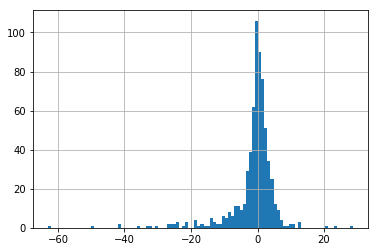

In [242]:
nlepts2['Error'].hist(bins=100)

In [243]:
for dis in nlepts1['District'].unique().tolist():
    var_dis = np.var(nlepts1.loc[nlepts1['District'] == dis,'iRate'].values)
    nlepts2.loc[nlepts2['District'] == dis,'Var'] = var_dis

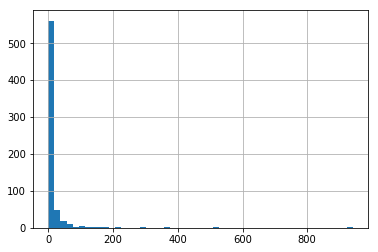

In [244]:
nlepts2['Var'].hist(bins=50)

# Model with group based on classification

In [245]:
nlepts2.to_excel('NLEP 2017.xlsx')

In [246]:
nlepts2 = gpd.GeoDataFrame(nlepts2,geometry=india.loc[india['NAME_2'] != 'The Dangs','geometry'].tolist())

In [247]:
exp5 = nlepts2[~((nlepts2['Error'] < 10) & (nlepts2['Error'] > -10))]
print(len(exp5)) #126

53


In [248]:
exp5.sort_values('Var')

,State,District,Year,iRate,pRate,RBD,iRate_sp,pRate_sp,Class,RiRate,...,Y*F,RBD*F,Class*F,RpRate*F,iRate_sp*F,Intercept,Pre,Error,Var,geometry
1129,Chhattisgarh,Jashpur,2017,37.275292,2.703251,0.589091,28.033275,1.728594,6.0,17.175767,...,6051.0,1.767273,18.0,3.639116,84.099824,1,19.422423,-17.852869,3.824113,"POLYGON ((83.84668731689482 23.22122192382818,..."
6239,Uttar Pradesh,Sitapur,2017,32.975257,1.767890,0.573144,18.209271,1.081573,4.0,23.811671,...,6051.0,1.719432,12.0,4.483321,54.627814,1,18.823382,-14.151876,4.329085,"POLYGON ((80.9739074707033 27.89097023010254, ..."
889,Bihar,Purnia,2017,41.760090,2.543545,0.559585,20.605570,1.285008,5.0,20.163439,...,6051.0,1.678756,15.0,4.180225,61.816711,1,18.114858,-23.645233,4.354869,"POLYGON ((87.00698089599621 25.7596111297608, ..."
3389,Madhya Pradesh,West Nimar,2017,30.286143,1.727142,0.583710,15.613907,1.164603,4.0,19.241765,...,6051.0,1.751131,12.0,4.106232,46.841722,1,17.063745,-13.222398,4.870277,"POLYGON ((76.09085083007841 22.53053092956554,..."
959,Bihar,Sitamarhi,2017,34.549558,1.559973,0.667718,11.450565,0.766473,3.0,14.513959,...,6051.0,2.003155,9.0,2.479141,34.351695,1,13.314191,-21.235367,5.332248,(POLYGON ((85.65391540527372 26.85042572021501...
2909,Madhya Pradesh,Anuppur,2017,36.871584,1.968993,0.620253,35.610555,2.405509,4.0,14.990516,...,6051.0,1.860759,12.0,3.344991,106.831666,1,23.100643,-13.770941,5.416101,"POLYGON ((81.78592681884771 22.87708091735846,..."
819,Bihar,Munger,2017,32.881338,2.187799,0.701613,16.796604,0.875732,5.0,13.949874,...,6051.0,2.104839,15.0,2.191183,50.389813,1,14.057951,-18.823387,6.725269,"POLYGON ((86.68749237060558 25.11802864074707,..."
2939,Madhya Pradesh,Barwani,2017,54.481488,4.509968,0.662338,21.410570,1.612494,6.0,17.825431,...,6051.0,1.987013,18.0,3.658904,64.231710,1,18.371668,-36.109820,7.470400,"POLYGON ((75.32338714599626 22.12796974182135,..."
1289,Daman and Diu,Daman,2017,4.863853,0.405321,0.666667,75.461753,3.990921,9.0,2.537234,...,2017.0,0.666667,9.0,0.338298,75.461753,1,28.694746,23.830893,8.045036,"POLYGON ((72.88378143310553 20.37022399902344,..."
1639,Gujarat,Vadodara,2017,13.330265,0.737977,0.609984,36.994827,2.253579,5.0,24.193568,...,6051.0,1.829953,15.0,4.452804,110.984480,1,25.803501,12.473236,8.499266,"POLYGON ((73.41285705566412 22.8098602294923, ..."


In [254]:
'Chandrapur' in nlepts[nlepts['iRate'] == 0]['District'].unique().tolist()

False

In [255]:
nlepts[nlepts['District'] == 'Chandrapur']

,State,District,Year,iRate,pRate,RBD,iRate_sp,pRate_sp,Class,RiRate,RpRate,Focus
3460,Maharashtra,Chandrapur,2008.0,23.355661,1.483231,0.501272,24.625737,1.364202,7.0,23.355661,1.483231,1
3461,Maharashtra,Chandrapur,2009.0,33.739380,2.407616,0.501272,24.625737,1.364202,6.0,23.355661,1.483231,1
3462,Maharashtra,Chandrapur,2010.0,45.785194,3.005531,0.566802,23.655108,1.577925,7.0,33.739380,2.407616,1
3463,Maharashtra,Chandrapur,2011.0,51.908113,3.117221,0.637712,25.851094,1.516878,7.0,45.785194,3.005531,1
3464,Maharashtra,Chandrapur,2012.0,55.950788,3.893205,0.550777,25.301954,1.481197,7.0,51.908113,3.117221,1
3465,Maharashtra,Chandrapur,2013.0,59.332660,4.061699,0.584239,29.296726,1.862239,7.0,55.950788,3.893205,-1
3466,Maharashtra,Chandrapur,2014.0,56.368999,3.827686,0.602895,33.604372,2.301561,6.0,59.332660,4.061699,-1
3467,Maharashtra,Chandrapur,2015.0,54.037986,3.389187,0.630618,26.231269,1.743757,7.0,56.368999,3.827686,-1
3468,Maharashtra,Chandrapur,2016.0,64.630024,3.589146,0.633851,31.336682,2.224675,6.0,54.037986,3.389187,-1
3469,Maharashtra,Chandrapur,2017.0,49.308433,2.636837,0.633851,29.071649,1.967927,6.0,64.630024,3.589146,3


In [256]:
nlepts2[nlepts2['District'] == 'Chandrapur']

,State,District,Year,iRate,pRate,RBD,iRate_sp,pRate_sp,Class,RiRate,...,Y*F,RBD*F,Class*F,RpRate*F,iRate_sp*F,Intercept,Pre,Error,Var,geometry
3469,Maharashtra,Chandrapur,2017,49.308433,2.636837,0.633851,29.071649,1.967927,6.0,64.630024,...,6051.0,1.901554,18.0,10.767438,87.214948,1,39.442227,-9.866206,154.054818,"POLYGON ((79.79656219482428 20.68351173400902,..."
